# Universidade Federal do Rio Grande do Norte
## Programa de Pós-graduação em Engenharia Elétrica e de Computação
### Course: Tópicos Especiais C - Data Science Foundation
### Professor: Ivanovitch Silva
### Students: 

* Aguinaldo Bezerra Batista Júnior
* Pedro Klisley Ferreira da Silva
* Ycaro Ravel Dantas

#### Activity: Project 3, Task 2
#### Subject: Analyzing Uber Rides
#### Objectives: Colect data and perform data analysis over Uber rides, using the Uber API and following guidance and hints in the professor's notebook
#### Dataset: uber-eta.csv

### 0 Loading libraries and doing some initializations

In [1]:
# Loading the necessary libraries
import os
import folium
import json
import pandas as pd
from branca.colormap import linear
import numpy as np
from shapely.geometry import Polygon
from shapely.geometry import Point
from numpy import random
from mpl_toolkits.basemap import Basemap
import requests
import time
import datetime
# Initialize basemap
bm = Basemap(resolution='c')

In [ ]:
# uber-rides can be installed using pip
# Loadion the uber client libs and start a session
from uber_rides.session import Session
from uber_rides.client import UberRidesClient

# Server token obtained by registering in the Uber developer site
from keys import UBER_API_KEY

session = Session(server_token=UBER_API_KEY)
uber_client = UberRidesClient(session)

### 1 Importing Geojson files from overpass-turbo project

First off, professor supplied a json format list containing coordinates of the neighboorhoods in the city of Natal/RN, Brazil and explained how it was obtained:

Source: http://overpass-turbo.eu/

Query to [Natal neighborhoods](http://wiki.openstreetmap.org/wiki/Natal#Bairros):

```python
[out:json][timeout:25];
{{geocodeArea:Natal RN Brasil}}->.searchArea;
(
  relation["admin_level"="10"](area.searchArea);
);
out body;
>;
out skel qt;
```

The supplied list has to be loaded in an appropriate way:

In [3]:
# import geojson file about natal neighborhood
natal_neigh = os.path.join('geojson', 'natal.geojson')

# load the data and use 'UTF-8'encoding
geo_json_natal = json.load(open(natal_neigh,encoding='UTF-8'))

We can list the neighborhoods and figure out better our city. We could also build all the polygons for each neighborhood.

In [4]:
neighborhood = []
polygons = []
poly_dict = {}
# list all neighborhoods
for neigh in geo_json_natal['features']:
        neighborhood.append(neigh['properties']['name'])
        polygons.append(Polygon(neigh['geometry']['coordinates'][0]))
        poly_dict[neigh['properties']['name']] = Polygon(neigh['geometry']['coordinates'][0])

### 2 Selection of Points

With the neighborhoods coordinates loaded, we may choose some random points inside the neighborhood's polygon to start the study. To make a criterious choice of the random points inside the polygons, we have developed three helper functions. Function on_water() uses the "On Water API" (https://onwater.io) to determine if a point is "on water" or not. Function potengi() checks if a point is within the boundaries of Potengi river, according to a specific geoJSON file. Function uber_availables() uses the Uber API to check if a valid response is given by the API for a point. The function is_land() of the Basemap library is also used to help in the point selection.

In [ ]:
# On Water API client function
from keys import ON_WATER_KEY
def on_water(lat,log):
    lat = str(lat)
    log = str(log)
    api_url="https://api.onwater.io/api/v1/results/"+lat+","+log+"?access_token="+ON_WATER_KEY
    try:
        onwater = requests.get(api_url,timeout=10).json()  
    except requests.exceptions.HTTPError as err:
        print(err)
        return False
        pass
    print("On Water")
    print(onwater['water'])
    time.sleep(5)
    return onwater['water']

We came accross a project which maintain geojson data about in-land waters in Brazil: https://marcelopiva.carto.com/tables/bra_water_areas_dcw_1/public/map
So, it was possible to gather coordinates of a big River in Natal, the Potengi River. With Potengi's bounds in hands we can apprimorate the in-land point check.

In [5]:
# import geojson file about potengi river bounds
potengi = os.path.join('geojson', 'potengi.geojson')

# load the data and use 'UTF-8'encoding
potengi_geojson = json.load(open(potengi,encoding='UTF-8'))

from shapely.geometry import shape, mapping

pontengi_multipoly = shape(potengi_geojson['features'][0]['geometry'])

# function definition
def potengi(point):
    for poly in pontengi_multipoly:
        polygon = Polygon(poly)
        if polygon.contains(point):
            return True
        else:
            return False

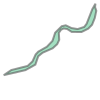

In [6]:
# shape of Potengi River
pontengi_multipoly

In [8]:
# Check valid response from Uber API
content_min_length = 50
def uber_available(lat,log):
    product = '65cb1829-9761-40f8-acc6-92d700fe2924'
    wait_time = uber_client.get_pickup_time_estimates(lat,log,product)
    #print(wait_time.headers.get('Content-Length'))
    #print(wait_time.json.get('times')[0]['estimate'])
    if int(wait_time.headers.get('Content-Length')) < content_min_length:
        print("Empty Uber Response")
        return False
    print("Uber Available")
    return True

The function generate_random() does the job of generate and select good points.

In [9]:
# return a number of points inside the polygon
# test if there's an Uber API response for them and if they are in land or water
def generate_random(number, polygon, neighborhood):
    list_of_points = []
    minx, miny, maxx, maxy = polygon.bounds
    counter = 0
    while counter < number:
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        pnt = Point(x, y)
        if polygon.contains(pnt):
            if bm.is_land(x,y):
                if not potengi(pnt):
                    if uber_available(y,x):
                        if not on_water(y,x):
                            list_of_points.append([x,y,neighborhood])
                            counter += 1
    return list_of_points

Thus, it is now possible to define a number of points and generate them:

In [ ]:
# Point generation
number_of_points = 3
all_points = []
# search all features
for feature in geo_json_natal['features']:
    # get the name of neighborhood
    neighborhood = feature['properties']['name']
    # take the coordinates (lat,log) of neighborhood
    geom = feature['geometry']['coordinates']
    # create a polygon using all coordinates
    polygon = Polygon(geom[0])
    # return number_of_points by neighborhood as a list [[log,lat],....]
    points = generate_random(number_of_points, polygon, neighborhood)
    all_points.extend(points)

all_points_df = pd.DataFrame(all_points)

filename = 'selected_points1.csv'
all_points_df.to_csv(filename, mode='w', header=True, index=False)

Because the use of Basemap and the online APIs, this point selection process takes too long. So, we have decided to run this process outside this notebook and load the resulting file back here. So all points were selected once.

### 3 Folium Map

In [23]:
# Loading the selected points generated externally
all_points_df = pd.read_csv('selected_points.csv')
all_points = all_points_df.values.tolist()

The Folium library is used to plot the selected poins in the map of Natal

In [24]:
# Create a map object
m = folium.Map(
    location=[-5.826592, -35.212558],
    zoom_start=11,
    tiles='Stamen Terrain'
)

# Configure geojson layer
folium.GeoJson(geo_json_natal).add_to(m)

In [25]:
for i,value in enumerate(all_points):
        log, lat, name = value 
        # Draw a small circle
        folium.CircleMarker([lat,log],
                    radius=2,
                    popup='%s %s%d %f %f' % (name, '#', i, lat, log),
                    color='red').add_to(m)
m

### 4 Retrieving data from Uber API

After selecting these points, we had to run a data collection procedure for a week. This procedure consists basicly on retrieve the ETA (Estimated Time to Arrive) for each selected point from the Uber API (for a given product id, in our case, UberX). To accomplish this, we have run the following piece of code:

```python
import os
import json
import numpy as np
import pandas as pd
import datetime as dt
import geohash
import time


from uber_rides.session import Session
from uber_rides.client import UberRidesClient

product = '65cb1829-9761-40f8-acc6-92d700fe2924'

all_points_df = pd.read_csv('selected_points1.csv')
all_points = all_points_df.values.tolist()

session = Session(server_token=UBER_API_KEY)
client = UberRidesClient(session)

uber_eta_df = pd.DataFrame(columns = ['datetime', 'log', 'lat', 'neigh', 'point_hash', 'eta'])


content_min_length = 50
max_rereq = 3
counter = 0
for i,value in enumerate(all_points):
        log, lat, name = value
        
        try:
            wait_time = client.get_pickup_time_estimates(lat,log,product)
            cont_len = wait_time.headers.get('Content-Length')
        except Exception as e:
             print e.__doc__
             print e.message
             cont_len = 0
        continue
    #print(wait_time.status_code)
    #print(wait_time.json)
    print(cont_len)
    while int(cont_len) < content_min_length:
                time.sleep(5)
        print("Re-requesting...")
        wait_time = client.get_pickup_time_estimates(lat,log,product)
        print(wait_time.headers.get('Content-Length'))
        counter += 1
        if counter >= 3:
                    break
                    print("Giving up after 3 attempts...")

    eta = wait_time.json.get('times')[0]['estimate']
 
    uber_eta_df =  uber_eta_df.append({
                 "datetime": dt.datetime.now(),
                 "log": log,
                 "lat": lat,
                 "neigh": name,
                 "point_hash": geohash.encode(lat,log),
                #"eta": 0
                 "eta": wait_time.json.get('times')[0]['estimate']
                  }, ignore_index=True)
          
        
uber_eta_df.to_csv('uber-eta.csv', mode='a', header=True, index=False)
```

This script retrieved data for a week from Uber API. The resulting file will be now loaded to a dataframe.

In [12]:
uber_eta_df = pd.read_csv('uber-eta.csv')

uber_eta_df.head()

,datetime,log,lat,neigh,point_hash,eta
0,2017-10-18 23:00:04.989364,-35.218999,-5.866646,Pitimbu,7nyyws423cfw,240.0
1,2017-10-18 23:00:05.895611,-35.242764,-5.863161,Pitimbu,7nyywh9h85dt,180.0
2,2017-10-18 23:00:06.740082,-35.222350,-5.871861,Pitimbu,7nyyw7pcgvb0,120.0
3,2017-10-18 23:00:07.608325,-35.249497,-5.858430,Planalto,7nyytvs05jmu,180.0
4,2017-10-18 23:00:08.664721,-35.267668,-5.850812,Planalto,7nyytqyuec8f,360.0


In [13]:
# Ignore numeric errors
uber_eta_df.eta = pd.to_numeric(uber_eta_df.eta, errors='coerce')

### 5 Choropeth Map

Now to start to build our choropleth we need to build a dictionary regarding each neighborhood and its mean ETA. 

In [14]:
uber_dict = uber_eta_df.groupby(['neigh'])['eta'].mean().to_dict()

list(uber_dict.items())

[('Alecrim', 237.41067844239262),
 ('Areia Preta', 256.49397590361446),
 ('Barro Vermelho', 261.37266706803132),
 ('Bom Pastor', 281.25301204819277),
 ('Candelária', 295.97913322632422),
 ('Capim Macio', 189.48002409154788),
 ('Cidade Alta', 265.72289156626505),
 ('Cidade Nova', 414.65836012861735),
 ('Cidade da Esperança', 239.66265060240963),
 ('Dix-Sept Rosado', 238.89267803410232),
 ('Felipe Camarão', 348.08186195826647),
 ('Guarapes', 523.91330523780857),
 ('Igapó', 274.22204376631197),
 ('Lagoa Azul', 502.46536839991967),
 ('Lagoa Nova', 244.40875326239711),
 ('Lagoa Seca', 223.10504117292629),
 ('Mãe Luiza', 396.53483236297933),
 ('Neópolis', 229.12703190848887),
 ('Nordeste', 283.00160513643658),
 ('Nossa Senhora da Apresentação', 338.50602409638554),
 ('Nossa Senhora de Nazaré', 235.06420545746388),
 ('Nova Descoberta', 266.36674030929908),
 ('Pajuçara', 317.94460056202331),
 ('Petrópolis', 231.57134256472006),
 ('Pitimbu', 286.07874648453196),
 ('Planalto', 401.82292712306764

Now, with min and max mean values for the ETA, we have to build a colormap:

In [15]:
# colormap yellow and green (YlGn)
colormap = linear.BuPu.scale(
    int(min(list(uber_dict.values()))),
    int(max(list(uber_dict.values())))).to_step(10)

print(colormap(1000.0))

colormap

#6e016b


Finally, it's possible to build a choropleth using the colormap and neighbors cordinates.

In [16]:
# Create a map object
m = folium.Map(
    location=[-5.826592, -35.212558],
    zoom_start=11,
    tiles='Stamen Terrain'
)

# Configure geojson layer
folium.GeoJson(
    geo_json_natal,
    name='Natal Neighborhoods Uber ETA',
    style_function=lambda feature: {
        'fillColor': colormap(uber_dict[feature['properties']['name']]),
        'color': 'black',
        'weight': 0.5,
        'dashArray': '5, 5',
        'fillOpacity': 0.7,
    }
).add_to(m)

colormap.caption = 'Natal Neighborhoods Uber ETA'
colormap.add_to(m)

# Addin markers for neighborhoods
for neigh in neighborhood:
        name = neigh
        x,y = poly_dict[neigh].centroid.coords.xy
        lat = y[0]
        log = x[0]
        eta = int(uber_dict.get(neigh))
        #Draw a small circle
        folium.CircleMarker([lat,log],
                   radius=3,
                   popup='%s%s%s%s'%(name, '. ETA: ', eta, 's'),
                   color='blue',
                   fill=False).add_to(m)


folium.LayerControl().add_to(m)

m

We just used <i>folium.CircleMarker</i> to make circles in the neighborhood's centers and popup the neighborhood's name and ETA. Another viable approach is to make the popups availables at the entire neighborhood's surface. To do so, we will plot the neighborhoods one by one and use <i>.add_child</i>.

In [17]:
# Create a map object
m = folium.Map(
    location=[-5.826592, -35.212558],
    zoom_start=11,
    tiles='Stamen Terrain'
)

# Configure geojson layer
for neigh in geo_json_natal['features']:
    gj = folium.GeoJson(
        {'features': [neigh]},
        name='Natal Neighborhoods Uber ETA',
        style_function=lambda feature: {
            'fillColor': colormap(uber_dict[feature['properties']['name']]),
            'color': 'black',
            'weight': 0.5,
            'dashArray': '5, 5',
            'fillOpacity': 0.7,
        }
    )
    gj.add_child(folium.Popup('%s%s%s%s'%(neigh['properties']['name'], '. ETA: ', int(uber_dict.get(neigh['properties']['name'])), 's')))
    gj.add_to(m)

colormap.caption = 'Natal Neighborhoods Uber ETA'
colormap.add_to(m)

folium.LayerControl().add_to(m)

m

Till now, we've been using the mean ETA for each neighborhood. It also could be necessary see how the ETA value evolves with the time.  

It is possible to make a timeslider on our choropleth map. We will use the approach described [here](https://github.com/halfdanrump/geoviz/blob/master/TimeSliderChoropleth.ipynb). To do that, we will need to convert our data and create a <i>styledict</i> readble by the TimeSliderChoropleth folium plugin. 

In [18]:
# get the timestamp in seconds from each datetime
# .astype('<M8[D]') will round the datetime to the corresponding day, ignoring hours, minutes, sec
# .strftime('%s') will convert the datetime in seconds

uber_eta_df['timestamp'] = pd.to_datetime(uber_eta_df['datetime'].values.astype('<M8[D]')).strftime('%s')
uber_eta_df.head()

,datetime,log,lat,neigh,point_hash,eta,timestamp
0,2017-10-18 23:00:04.989364,-35.218999,-5.866646,Pitimbu,7nyyws423cfw,240.0,1508295600
1,2017-10-18 23:00:05.895611,-35.242764,-5.863161,Pitimbu,7nyywh9h85dt,180.0,1508295600
2,2017-10-18 23:00:06.740082,-35.222350,-5.871861,Pitimbu,7nyyw7pcgvb0,120.0,1508295600
3,2017-10-18 23:00:07.608325,-35.249497,-5.858430,Planalto,7nyytvs05jmu,180.0,1508295600
4,2017-10-18 23:00:08.664721,-35.267668,-5.850812,Planalto,7nyytqyuec8f,360.0,1508295600


In [19]:
# group by neigh and day and assigning the corresponding color based on colormap

uber_eta_df_group = uber_eta_df.groupby(['neigh', 'timestamp'], as_index=False).mean()
uber_eta_df_group['color'] = uber_eta_df_group.eta.apply(lambda x: colormap(x))
uber_eta_df_group.head()

,neigh,timestamp,log,lat,eta,color
0,Alecrim,1508295600,-35.219431,-5.803676,210.000000,#edf8fb
1,Alecrim,1508382000,-35.219431,-5.803676,216.737589,#edf8fb
2,Alecrim,1508468400,-35.219431,-5.803676,229.343066,#cfe0ed
3,Alecrim,1508554800,-35.219431,-5.803676,221.788618,#edf8fb
4,Alecrim,1508641200,-35.219431,-5.803676,269.380531,#b4cce2


In [20]:
# assigning ids to the neighborhoods
neigh_id = pd.DataFrame({'neigh': neighborhood, 'id': list(range(36))}).set_index('neigh')
neigh_id.id = neigh_id.id.astype(str)

# assigning ids to the neighborhoods in geo_json data
for neigh_feature in geo_json_natal['features']:
    neigh = neigh_feature['properties']['name']
    neigh_feature['id'] = neigh_id.loc[neigh,'id']
    
# creating the style dict
styledict = {}
for neigh in neighborhood:
    styledict[neigh_id.loc[neigh,'id']] =  {int(time): {'color':  uber_eta_df_group[(uber_eta_df_group.neigh==neigh)&(uber_eta_df_group.timestamp.astype(int)==time)]['color'].values[0], 'opacity': 1} for time in uber_eta_df_group[(uber_eta_df_group.neigh==neigh)].timestamp.astype(int)}

In [21]:
from folium.plugins import TimeSliderChoropleth

m = folium.Map(location=[-5.826592, -35.212558],
    zoom_start=11,
    tiles='Stamen Terrain')

g = TimeSliderChoropleth(
    geo_json_natal,
    styledict = styledict
).add_to(m)

m